# load library

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer 
#from sklearn.preprocessing import Imputer
#ERROR:https://min-2.tistory.com/10
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.utils import shuffle

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

pd.set_option("display.max_columns",100)

# load data

In [248]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")

**Data at first sight**
* feature that belong to **similar grouping are tagged** as such in feature names (ex. ind, reg, car, calc)
* feature names include the postfix **bin** to indicate binary features and **cat** to indicate categorical features
* features **without these designations are either continuous or ordinal**
* values of **-1** indicate that the features was **missing** from the observation
* **target** columns siginifies whether or not a claim was filed for that policy holder

In [249]:
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


indeed see the following
* binary variables
* categorical variables of which the category value are integers
* other variables with integer or float values
* variables with 01 represent missing values
* target variable and ID variable

check number of rows and columns in trian data

In [250]:
train.shape

(595212, 59)

check if there are same number of variables

In [251]:
train.drop_duplicates()
train.shape

(595212, 59)

In [252]:
test.shape

(892816, 58)

In [253]:
test.drop_duplicates()
test.shape

(892816, 58)

* bin variable : already binary -> no dummification
* cat variable : 14 category -> need to create dummy variable

>**no null values presented**
>-> all missing values replaced by **-1**

In [254]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

# Metadata
* to facilitate data management, store meta- information about variables in df<br>

store
* role : input, ID, target
* level : nominal, interval,ordinal, binary
* keep : True or False
* dtype : int, float, str

In [255]:
data = []
for f in train.columns:
    # Defining the role
    if f == 'target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
         
    # Defining the level
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    # Initialize keep to True for all variables except for id
    keep = True
    if f == 'id':
        keep = False
    
    # Defining the data type 
    dtype = train[f].dtype
    
    # Creating a Dict that contains all the metadata for the variable
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)
    
meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
meta.set_index('varname', inplace=True)

In [256]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [257]:
#extract all nomial var that are not dropped
meta[(meta.level == 'nominal') & (meta.keep)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

In [258]:
#display number of variable per role and level
pd.DataFrame({"count":meta.groupby(["role","level"])["role"].size()}).reset_index()

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


# Descriptive statistic
* apply describe method on df
* not make sense to categorical var and id -> explore visually later
* use metadata - easily select per data type

**Interval variable**

**reg variable**
* only `pg_reg_03` has missing value
* range differ between variables -> apply scaling

**car variable**
* `ps_car_12` and `ps_car_15` has missing value
* range differ between variables -> apply scaling

**calc variable**
* no missing value
* maxium ration : 0.9

**Overall**
* range of interval variable is rather small
* some transformation (ex.log) already applied in order to anonymize data?

In [259]:
v=meta[(meta.level=="interval")&(meta.keep)].index
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


**Ordinal variable**

* `ps_car_11` has missing variable
* different range -> apply scaling

In [260]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


**Binary variable**
* **strongly imbalanced** : priori in trian data 3.645%
* most variables the value is zero in most case

In [261]:
v = meta[(meta.level == 'binary') & (meta.keep)].index
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Handling imbalanced classes
The proportion of recoed with `target=1` is far less than `target=0`. <br>This lead to model that has great accuracy but does have any added value in pratice.<br> Two possible strategies to dela with this problem are
* over-sampling records with `target=1`
* under-sampling recoreds with `target=0`<br>

As we have large train set, we can go for undersampling.<br>



In [262]:
desired_apriori=0.10

#get the indices per target value
idx_0=train[train.target==0].index
idx_1=train[train.target==1].index

#get original number of recored per target value
nb_0=len(train.loc[idx_0])
nb_1=len(train.loc[idx_1])

#calculate undersampling rate and resulting number of records with target=0
undersampling_rate=((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
undersampled_nb_0=int(undersampling_rate*nb_0)
print("Rate to undersample records with terget=0 : {}".format(undersampling_rate))
print("Number of records with target=0 after undersampling : {}".format(undersampled_nb_0))

#radomly select recored with target=0 to get at the desired a priori
undersampled_idx=shuffle(idx_0,random_state=37,n_samples=undersampled_nb_0)

#construct list with remaining indices
idx_list=list(undersampled_idx)+list(idx_1)

#return undersample data frame
train=train.loc[idx_list].reset_index(drop=True)

Rate to undersample records with terget=0 : 0.34043569687437886
Number of records with target=0 after undersampling : 195246


In [263]:
test.shape

(892816, 58)

# Data Quality check
**check missing values**
missing are represented as `-1`

* `ps_car_03_cat` & `ps_car_05_cat`<br>
large proportion of record with missing value -> remove
* `ps_reg_03` <br>
18% missing continuous values -> replace by mean
* `ps_car_11`<br>
5 missing oridinal values -> replace by mode
* `ps_car_12`<br>
1 missing continous values -> replace by mean
* `ps_car_14`<br>
7% missing continous values -> replace by mean

In [264]:
vars_with_missing=[]
for f in train.columns:
  missings=train[train[f]==-1][f].count()
  if missings>0:
    vars_with_missing.append(f)
    missings_prec=missings/train.shape[0]

    print("Variable {} has {} records ({:.2%}) with missing values".format(f,missings,missings_prec))

print("In total, there are {} variables with missing values".format(len(vars_with_missing)))

Variable ps_ind_02_cat has 103 records (0.05%) with missing values
Variable ps_ind_04_cat has 51 records (0.02%) with missing values
Variable ps_ind_05_cat has 2256 records (1.04%) with missing values
Variable ps_reg_03 has 38580 records (17.78%) with missing values
Variable ps_car_01_cat has 62 records (0.03%) with missing values
Variable ps_car_02_cat has 2 records (0.00%) with missing values
Variable ps_car_03_cat has 148367 records (68.39%) with missing values
Variable ps_car_05_cat has 96026 records (44.26%) with missing values
Variable ps_car_07_cat has 4431 records (2.04%) with missing values
Variable ps_car_09_cat has 230 records (0.11%) with missing values
Variable ps_car_11 has 1 records (0.00%) with missing values
Variable ps_car_14 has 15726 records (7.25%) with missing values
In total, there are 12 variables with missing values


In [265]:
# drop variable with too many missing values
vars_to_drop=["ps_car_03_cat","ps_car_05_cat"]
train.drop(vars_to_drop,inplace=True,axis=1)

meta.loc[(vars_to_drop),"keep"]=False #updating the meta

#imputing with the mean or mode
mean_imp=SimpleImputer(missing_values=-1,strategy="mean")
mode_imp=SimpleImputer(missing_values=-1,strategy="most_frequent")

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()



In [266]:
test.drop(vars_to_drop,inplace=True,axis=1)

test['ps_reg_03'] = mean_imp.fit_transform(test[['ps_reg_03']]).ravel()
test['ps_car_12'] = mean_imp.fit_transform(test[['ps_car_12']]).ravel()
test['ps_car_14'] = mean_imp.fit_transform(test[['ps_car_14']]).ravel()
test['ps_car_11'] = mode_imp.fit_transform(test[['ps_car_11']]).ravel()

**checking the cardinality of the categorical variable**
* cardinality : different values number
* check there are variable with many distinct values

`ps_cat_11_cat` : many distinct value 

In [267]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    dist_values = train[f].value_counts().shape[0]
    print('Variable {} has {} distinct values'.format(f, dist_values))

Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 3 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


In [268]:
# Script by https://www.kaggle.com/ogrellier
# Code: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

#Smoothing is computed like in the following paper by Daniele Micci-Barreca
#https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf

In [269]:
def add_noise(series,noise_level):
  return series*(1+noise_level*np.random.randn(len(series)))

  * `trn_series` : training categorical feature as a pd.Series
  * `tst_serie`s : test categorical feature as a pd.Series
  * `target` : target data as a pd.Series
  * `min_samples_leaf (int)` : minimum samples to take category average into account
  * `smoothing (int)` : smoothing effect to balance categorical average vs prior  

In [270]:
def target_encode(trn_series=None, tst_series=None,target=None, min_samples_leaf=1,smoothing=1,noise_level=0):
  assert len(trn_series)==len(target)
  assert trn_series.name==tst_series.name
  temp=pd.concat([trn_series,target],axis=1)

  #compute target mean
  averages=temp.groupby(by=trn_series.name)[target.name].agg(["mean","count"])
  #compute smoothing
  smoothing=1/(1+np.exp(-(averages["count"]-min_samples_leaf)/smoothing))
  #apply average function to all target data
  prior=target.mean()
  #bigger the count the less full_avg is taken into account
  averages[target.name]=prior*(1-smoothing)+averages["mean"]*smoothing
  averages.drop(["mean","count"],axis=1,inplace=True) 
  #apply average to trn series
  ft_trn_series=pd.merge(trn_series.to_frame(trn_series.name),
                         averages.reset_index().rename(columns={"index":target.name,target.name:"average"}),
                         on=trn_series.name,
                         how="left")["average"].rename(trn_series.name+"mean").fillna(prior)
  #pd.marge do not keep index so restore it
  ft_trn_series.index=trn_series.index
  #apply average to tst series
  ft_tst_series=pd.merge(tst_series.to_frame(tst_series.name),
                               averages.reset_index().rename(columns={"index":target.name, target.name:"average"}),
                               on=tst_series.name,
                               how="left")["average"].rename(trn_series.name+"mean").fillna(prior)


  #pd.merge dono keep index so restore it
  ft_tst_series.index=tst_series.index
  return add_noise(ft_trn_series,noise_level),add_noise(ft_tst_series,noise_level)

In [271]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)
    
train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
meta.loc['ps_car_11_cat','keep'] = False  # Updating the meta


In [272]:
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# Exploratory Data Visualization
**catagorical variable**

* there are variable with missing values <br>-> keep missing vlaues as separate category value, not as mode for instance
* customer with missing value appear to have much higher probabilty at ask insurance claim

<Figure size 432x288 with 0 Axes>

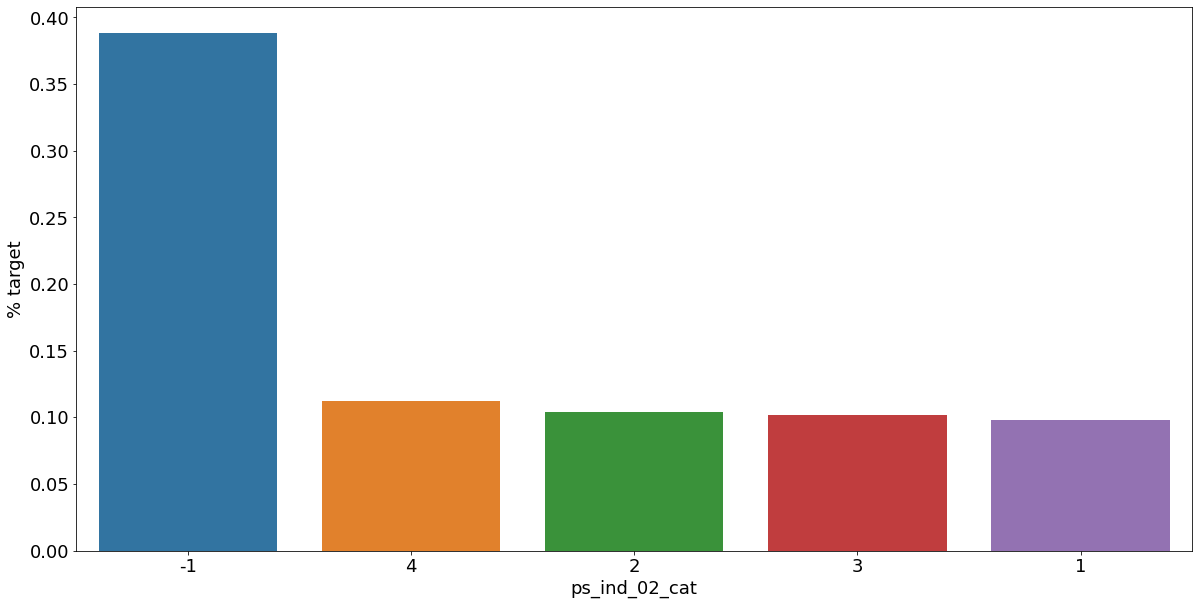

<Figure size 432x288 with 0 Axes>

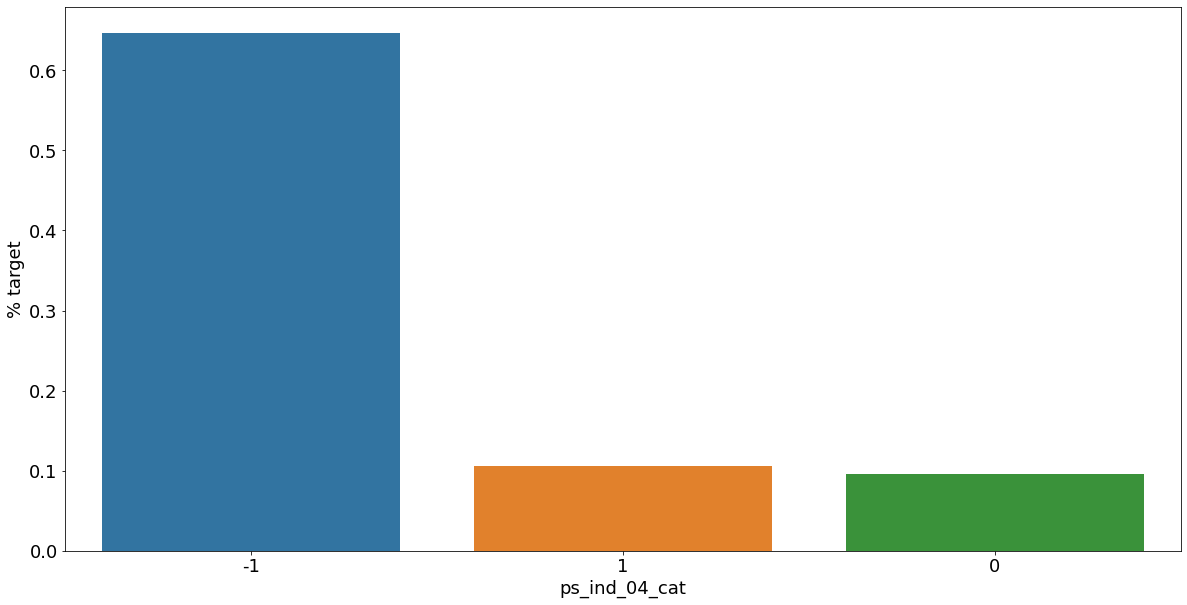

<Figure size 432x288 with 0 Axes>

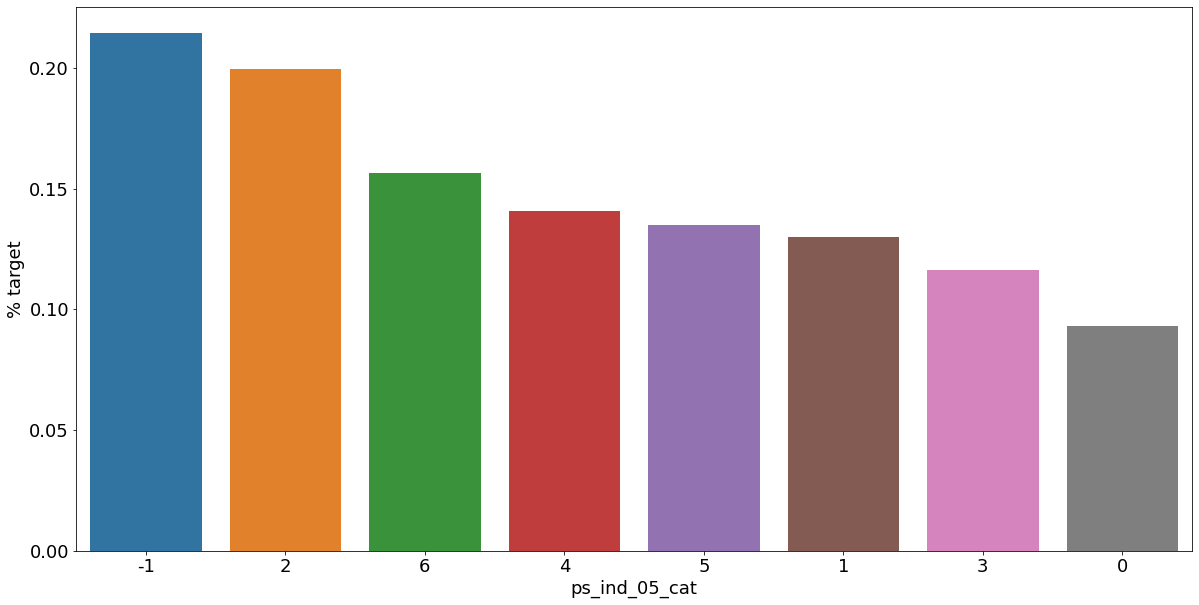

<Figure size 432x288 with 0 Axes>

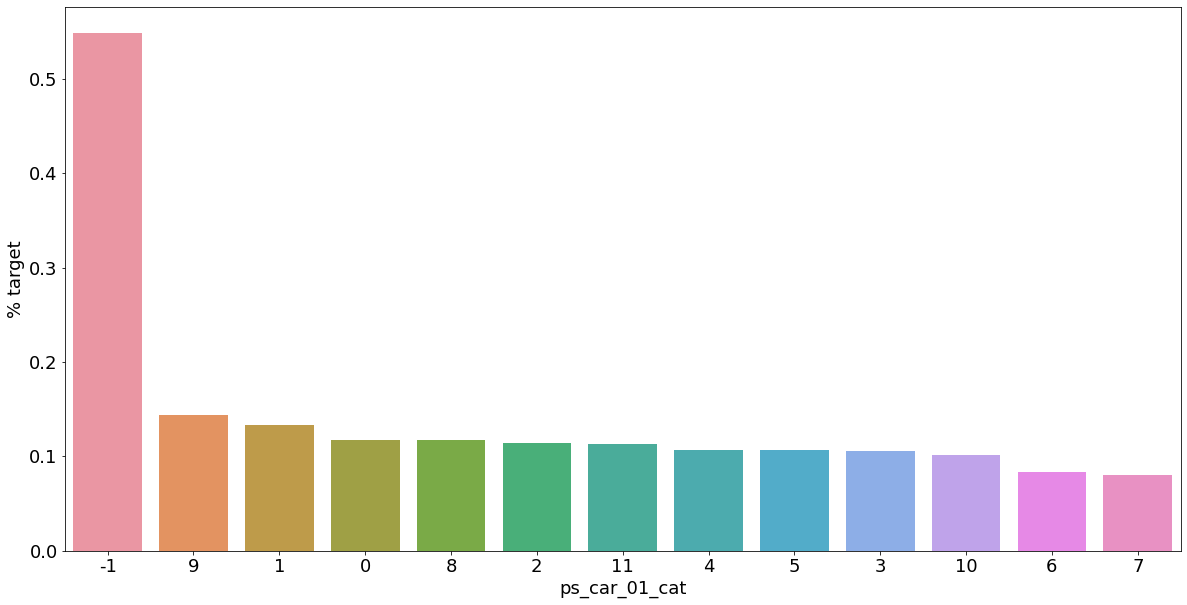

<Figure size 432x288 with 0 Axes>

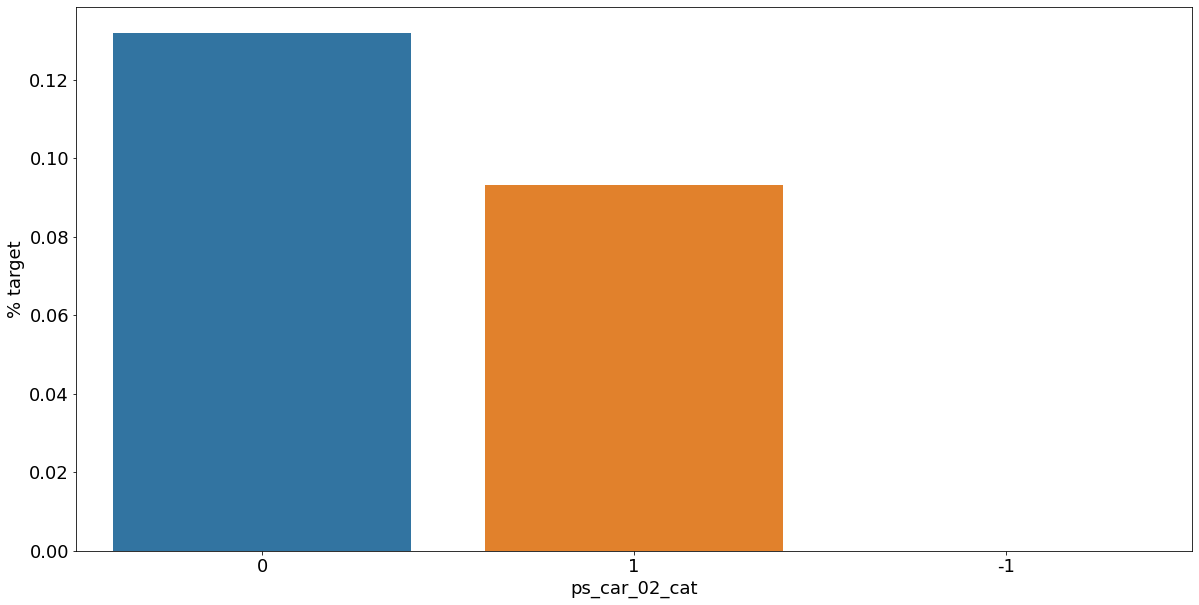

<Figure size 432x288 with 0 Axes>

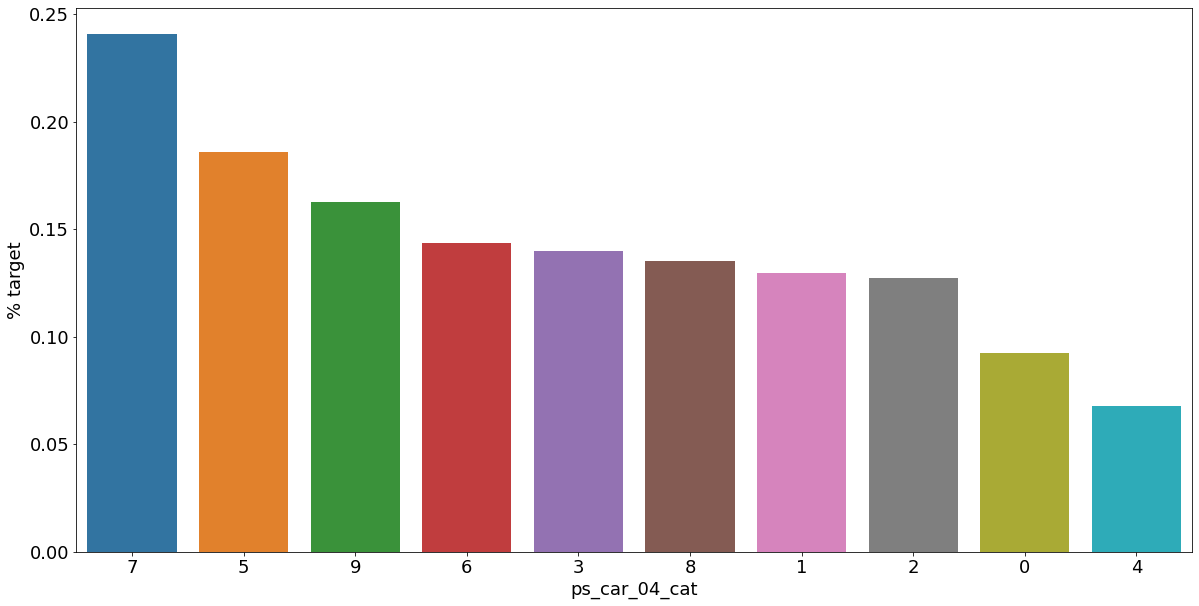

<Figure size 432x288 with 0 Axes>

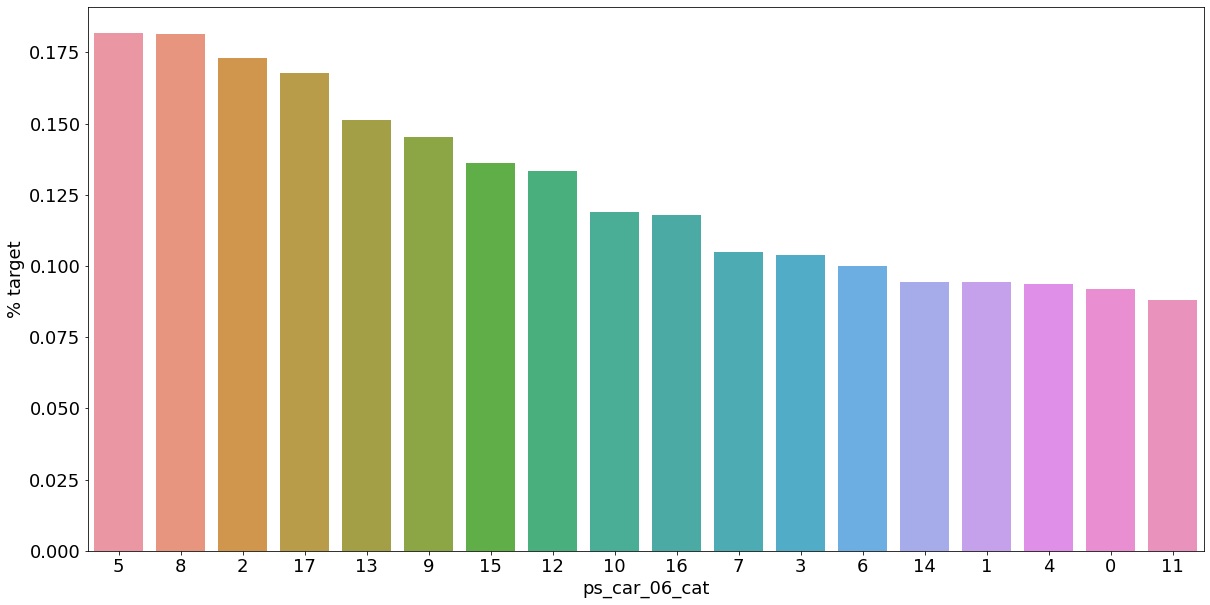

<Figure size 432x288 with 0 Axes>

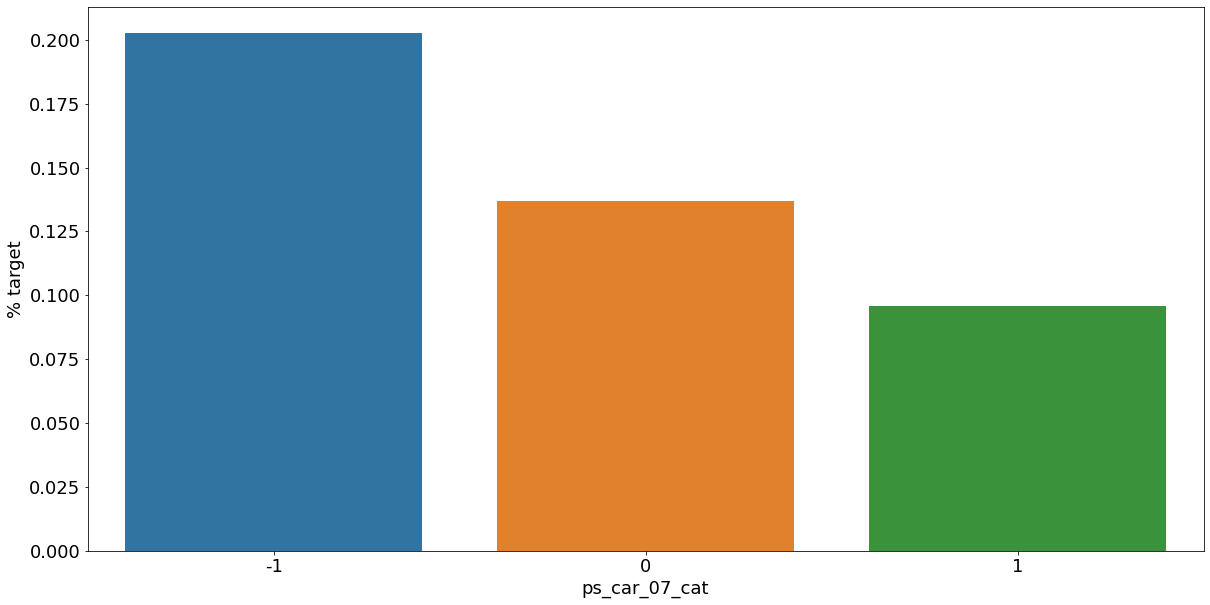

<Figure size 432x288 with 0 Axes>

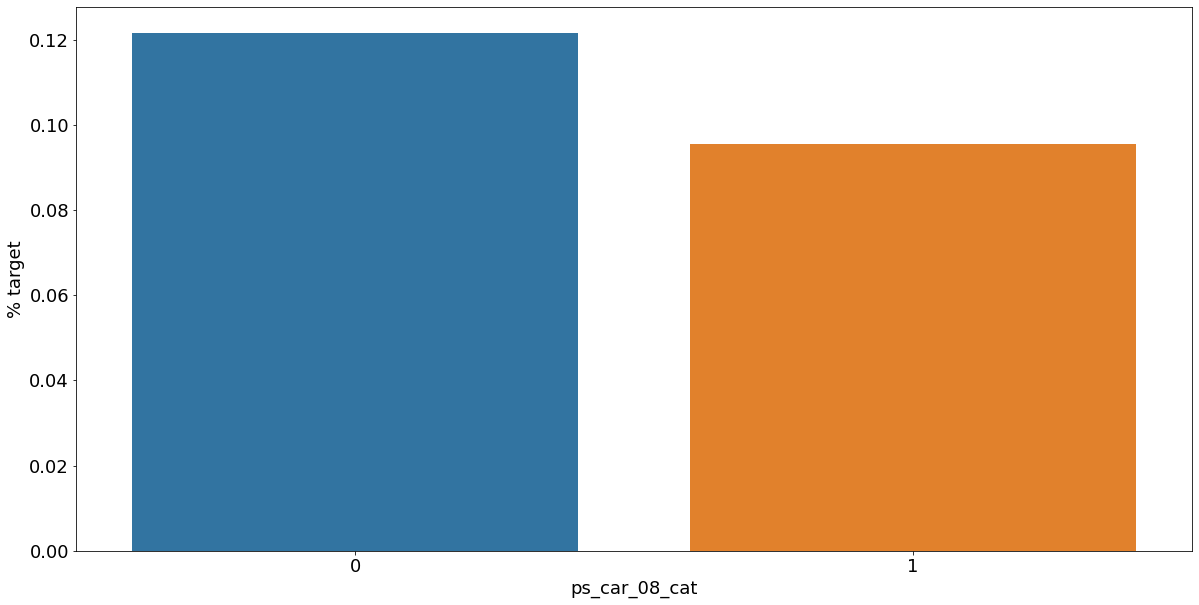

<Figure size 432x288 with 0 Axes>

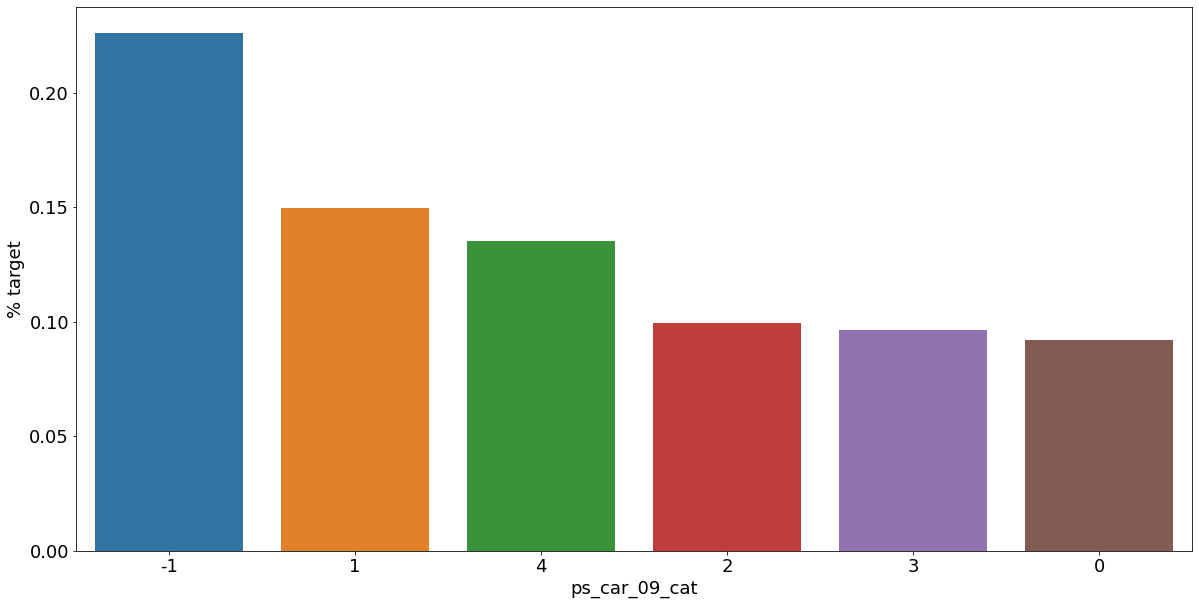

<Figure size 432x288 with 0 Axes>

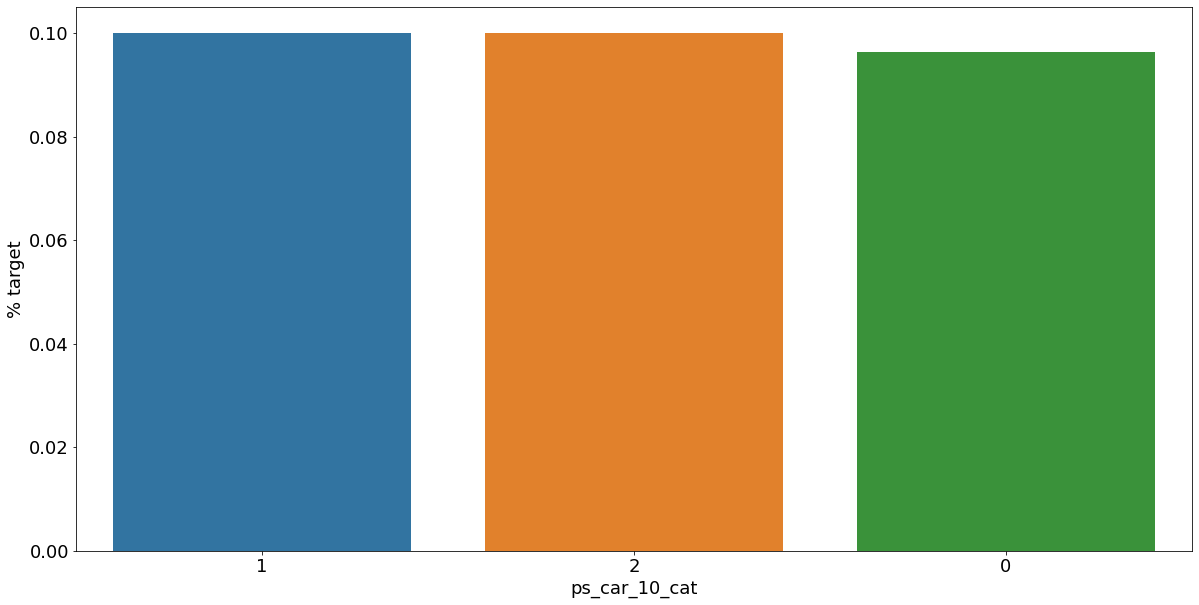

In [273]:
v=meta[(meta.level=="nominal")&(meta.keep)].index

for f in v:
  plt.figure()
  fig,ax=plt.subplots(figsize=(20,10))

  #calculate the percentage of target=1 per categorical value
  cat_perc = train[[f, 'target']].groupby([f],as_index=False).mean()
  cat_perc.sort_values(by='target', ascending=False, inplace=True)

  #bar plot : order the bars descending on target mean
  sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
  plt.ylabel("% target",fontsize=18)
  plt.xlabel(f, fontsize=18)
  plt.tick_params(axis="both",which="major",labelsize=18)
  plt.show()


**Interval variable**
* check correlation between interval variable
* use heatmap

strong correlations between the variable:
* `ps_reg_02` & `ps_reg_03` : 0.7
* `ps_car_12` & `ps_car_13` : 0.67
* `ps_car_12` & `ps_car_14` : 0.58
* `ps_car_13` & `ps_car_15` : 0.67

In [274]:
def corr_heatmap(v):
  correlations=train[v].corr()

  #create color map ranging between two colors
  cmap=sns.diverging_palette(220,10,as_cmap=True)
  fig,ax=plt.subplots(figsize=(10,10))
  sns.heatmap(correlations,cmap=cmap,vmax=1.0,center=0,fmt=".2f",
              square=True, linewidths=.5,
              annot=True,cbar_kws={"shrink":.75}) 
  plt.show()

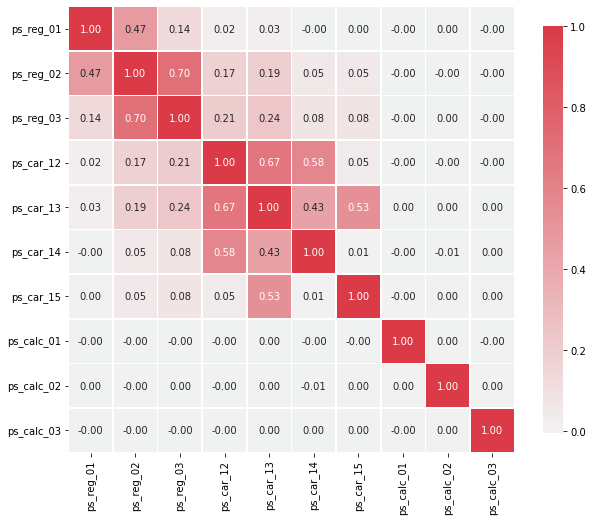

In [275]:
v=meta[(meta.level=="interval")&(meta.keep)].index
corr_heatmap(v)

In [276]:
#take sample for train data to speed up process
s=train.sample(frac=0.1)

`ps_reg_02` & `ps_reg_03`
* linear relationship
* regression line for `target=1` and `target=0` is same

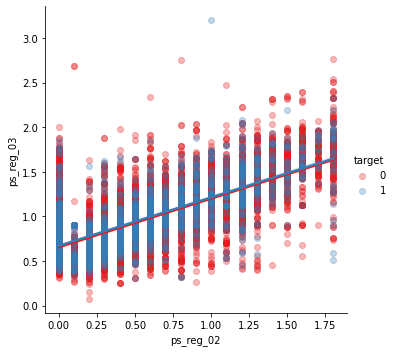

In [277]:
sns.lmplot(x="ps_reg_02",y="ps_reg_03",
           data=s,hue="target",palette="Set1",
           scatter_kws={"alpha":0.3})
plt.show()

`ps_car_12` & `ps_car_14`

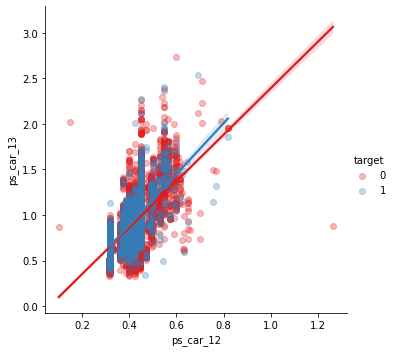

In [278]:
sns.lmplot(x="ps_car_12",y="ps_car_13",
           data=s,hue="target",palette="Set1",
           scatter_kws={"alpha":0.3})
plt.show()

`ps_car_13` & `ps_car_15`

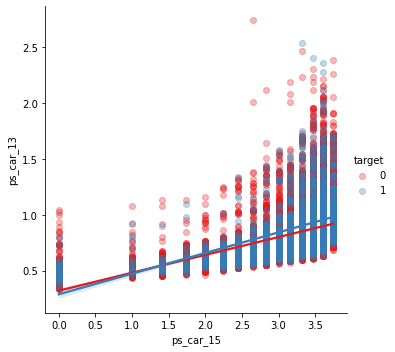

In [279]:
sns.lmplot(x="ps_car_15",y="ps_car_13",
           data=s,hue="target",palette="Set1",
           scatter_kws={"alpha":0.3})
plt.show()

**PCA (Principal Component Analysis)**
* reduce the dimension on variable
* decide which of the correlated variable to keep<br>

the number of correlated variable is rather low, we let model to do heavy lifting

**check the correlation between oridinal variable**

* not correlation in ordinal variable
* look now distribution are when grouping by target value

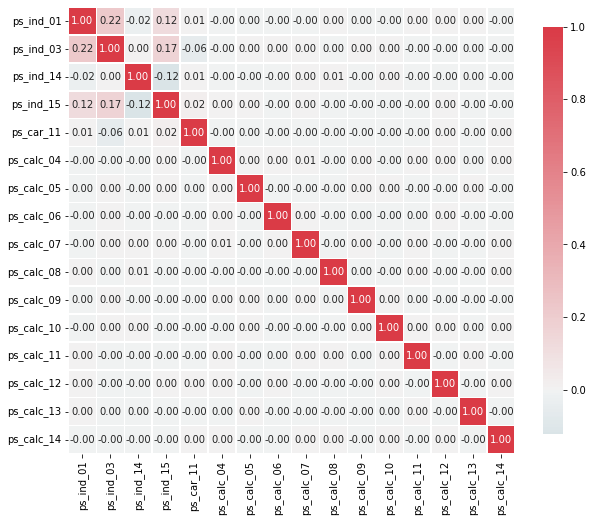

In [280]:
v=meta[(meta.level=="ordinal")&(meta.keep)].index
corr_heatmap(v)

# Feature Engineering

**creating dummy variable**
* categorical variable : no any order or magnitude
* drop the first dummy variable as this information can be derived from the other dummy variables generated for the categories of the original variable

In [281]:
v=meta[(meta.level=="nominal")&(meta.keep)].index
print("Before dummification we have {} variables in train".format(train.shape[1]))

Before dummification we have 57 variables in train


In [282]:
train=pd.get_dummies(train,columns=v,drop_first=True)
print("After dummification we have {} variables in train".format(train.shape[1]))

After dummification we have 109 variables in train


In [283]:
test=pd.get_dummies(test,columns=v,drop_first=True)
print("After dummification we have {} variables in test".format(test.shape[1]))

After dummification we have 108 variables in test


* creating dummy variable add 52 variable to training set

**creating interaction variable**

* add extra interaction variables to trian data
* use *get_feature_names* method, assign column names to new variables

In [284]:
v=meta[(meta.level=="interval")&(meta.keep)].index
poly=PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
interactions=pd.DataFrame(data=poly.fit_transform(train[v]),columns=poly.get_feature_names(v))
interactions.drop(v,axis=1,inplace=True) #remove original columns

In [285]:
#concat interaction variable to train data
print("Before creating interaction we have {} variables in train".format(train.shape[1]))
train=pd.concat([train,interactions],axis=1)
print("After creating interaction we have {} variables in train".format(train.shape[1]))

Before creating interaction we have 109 variables in train
After creating interaction we have 164 variables in train


In [286]:
interactions=pd.DataFrame(data=poly.fit_transform(test[v]),columns=poly.get_feature_names(v))
interactions.drop(v,axis=1,inplace=True) #remove original columns

In [287]:
#concat interaction variable to test data
print("Before creating interaction we have {} variables in test".format(test.shape[1]))
test=pd.concat([test,interactions],axis=1)
print("After creating interaction we have {} variables in test".format(test.shape[1]))

Before creating interaction we have 108 variables in test
After creating interaction we have 163 variables in test


In [288]:
test.shape

(892816, 163)

# Feature selection
**removing feature with low or zero variance**
* `VarianceThreshold` : remove features with zero variance<br>

In this competition as we saw there are no zero-variance variable in previous steps. <br>
if we remove features with less than 1% variance, remove 31 variables

In [289]:
selector=VarianceThreshold(threshold=.01)
selector.fit(train.drop(["id","target"],axis=1)) #fit to train without id and target variables

f=np.vectorize(lambda x : not x) #function to toggle boolean array elements

v=train.drop(["id","target"],axis=1).columns[f(selector.get_support())]

print("{} variables have too low variance".format(len(v)))
print("These variables are {}".format(list(v)))

28 variables have too low variance
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


would lose rather many variable if we would select based on variance<br>
but we do not have many variable, we will let classifier chose<br>
if dataset with many more variable this coudle reduce processing time

**Select feature with Random Forest and SelectFromModel**
* base feature selection on feature importances of `randomforest`
* use sklearn `SelectFromModel` able to select how many variable want to keep<br>

you can able to set threshold on level of feature importance manually<br>
this time we will simply select top 50% best variable


In [290]:
X_train=train.drop(["id","target"],axis=1)
y_train=train["target"]

feat_labels=X_train.columns

rf=RandomForestClassifier(n_estimators=150,max_depth=8, min_samples_leaf=4, max_features=0.2,random_state=0,n_jobs=-1)
rf.fit(X_train,y_train)
importances=rf.feature_importances_
indices=np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f"%(f+1, 30, feat_labels[indices[f]],importances[indices[f]]))

 1) ps_ind_05_cat_0                0.074782
 2) ps_car_11_cat_te               0.044050
 3) ps_car_13                      0.042556
 4) ps_car_13^2                    0.042138
 5) ps_ind_17_bin                  0.042095
 6) ps_reg_03 ps_car_13            0.036899
 7) ps_car_12 ps_car_13            0.034832
 8) ps_car_13 ps_car_15            0.026720
 9) ps_reg_01 ps_car_13            0.025155
10) ps_reg_02 ps_car_13            0.024984
11) ps_ind_03                      0.022540
12) ps_car_13 ps_car_14            0.019315
13) ps_reg_01 ps_reg_03            0.016666
14) ps_car_07_cat_1                0.016116
15) ps_reg_03 ps_car_12            0.016024
16) ps_reg_02 ps_car_15            0.015184
17) ps_car_12 ps_car_15            0.014940
18) ps_ind_15                      0.013639
19) ps_reg_02 ps_car_12            0.012218
20) ps_reg_03 ps_car_14            0.011954
21) ps_reg_02 ps_reg_03            0.011524
22) ps_car_14^2                    0.011324
23) ps_reg_03^2                 

`SelectFromModel` : specify which prefit classifier to use and what the threhold is for feature importances<br>
`get_support` : limit the number of variables in train data

In [291]:
sfm=SelectFromModel(rf,threshold="median",prefit=True)
print("Number of features before selection: {}".format(X_train.shape[1]))

n_features=sfm.transform(X_train).shape[1]
print("Number of features after selection: {}".format(n_features))

selected_vars=list(feat_labels[sfm.get_support()])

Number of features before selection: 162
Number of features after selection: 81


In [292]:
test.shape

(892816, 163)

In [293]:
X_train = train[selected_vars]
y_train=train["target"].values
test_id=test['id'].values
test=test[selected_vars]

In [294]:
print("Train dataset (rows, cols):",X_train.values.shape, "\nTest dataset (rows, cols):",test.values.shape)

Train dataset (rows, cols): (216940, 81) 
Test dataset (rows, cols): (892816, 81)


# Feature Scaling
* apply standard scaling

In [295]:
scaler=StandardScaler()
scaler.fit_transform(X_train)

array([[-0.45941104, -1.26665356,  1.25877984, ...,  0.33629291,
        -1.00982477, -1.01071913],
       [ 1.55538958,  0.95034274,  1.25877984, ..., -1.01051216,
        -0.41144469, -1.01071913],
       [ 1.05168943, -0.52765479,  1.25877984, ...,  0.33629291,
        -0.86022975, -0.56215309],
       ...,
       [-0.9631112 ,  0.58084336, -0.7944201 , ..., -0.01287878,
         0.48612543,  0.18545696],
       [-0.9631112 , -0.89715418,  1.25877984, ..., -0.51169547,
         0.48612543, -0.41263108],
       [-0.45941104, -1.26665356, -0.7944201 , ..., -0.41193213,
        -0.71063473, -0.11358706]])

In [296]:
x_train_scaled = scaler.transform(X_train)
x_test_scaled = scaler.transform(test)

# Prepare the model

**Ensable class for cross validation and ensamble**<br><br>
prepare Ensmable class to spkit data in KFolds, train models and ensamble results<br>
the class has an **init** method (called when ensamble object is created) that accepts 4 paramaeters:<br>
* self : the object to be initialized
* n_splits : the number of cross-validation split to be used
* stacker : model used for stacking the prediction result from the trained based model
* base_model : the list of base models used in training<br>

A second method, **fit_predict** has four functions: <br>
* split training data in **n_split** folds
* run **base models** for each fold
* performance prediction using each model
* ensamble result using **stacker**




In [297]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

**Parameters for th base model**<br><br>
For the base models, we prepare thress different LightGBM models and one XGB model.<br>
Each model is used to train data (using as well cross-validation with 3 folds)



In [298]:
# LightGBM params
#lgb_1
lgb_params1={}
lgb_params1["learning_rate"]=0.02
lgb_params1["n_estimatrs"]=650
lgb_params1["max_bin"]=10
lgb_params1["subsample"]=0.8
lgb_params1["subsample_freq"]=10
lgb_params1["colsample_bytree"]=0.8
lgb_params1["min_child_samples"]=500
lgb_params1["seed"]=314
lgb_params1["num_threads"]=4

#lgb_2
lgb_params2={}
lgb_params2["learning_rate"]=0.02
lgb_params2["n_estimatrs"]=1090
lgb_params2["subsample"]=0.7
lgb_params2["subsample_freq"]=2
lgb_params2["colsample_bytree"]=0.3
lgb_params2["num_leaves"]=16
lgb_params2["seed"]=314
lgb_params2["num_threads"]=4

#lgb_3
lgb_params3={}
lgb_params3["learning_rate"]=0.02
lgb_params3["n_estimatrs"]=1100
lgb_params3["max_depth"]=4
lgb_params3["seed"]=314
lgb_params3["num_threads"]=4

#XGBoost params
xgb_params={}
xgb_params["objective"]="binary:logistic"
xgb_params["learning_rate"]=0.04
xgb_params["n_estimators"]=490
xgb_params["max_depth"]=4
xgb_params["subsample"]=0.9
xgb_params["colsample_bytree"]=0.9
xgb_params["min_child_weight"]=10
xgb_params["num_threads"]=4

**Initialize models with parameters**<br><br>
We init 3 base models and stacking model. For the base models we are using the predefined parameters initialized above.

In [299]:
#Base models
lgb_model1=LGBMClassifier(**lgb_params1)
lgb_model2=LGBMClassifier(**lgb_params2)
lgb_model3=LGBMClassifier(**lgb_params3)
xgb_model=XGBClassifier(**xgb_params)

#stacking model
log_model=LogisticRegression()

**Initialize the ensambling object**<br><br>
using Ensamble.init we init the stacking object

In [300]:
stack=Ensemble(n_splits=3,
               stacker=log_model,
               base_models=(lgb_model1,lgb_model2,lgb_model3,xgb_model))

# Run predictive model<br>
calling the **fit_predict** method of **stack** object, we run the training of the base models, predict the **target** with each models, ensamble the results using **stacker** model and output the stacked result

In [301]:
y_prediction=stack.fit_predict(x_train_scaled  ,y_train,x_test_scaled )

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.63024 [gini]: 0.26049
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.63163 [gini]: 0.26325
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.62844 [gini]: 0.25688
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.62828 [gini]: 0.25656
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.62912 [gini]: 0.25824
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.62608 [gini]: 0.25216
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.62723 [gini]: 0.25445
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.62772 [gini]: 0.25544
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.62571 [gini]: 0.25142
Base model 4: fit XGBClassifier model | fold 1
cross_score [roc-auc]: 0.63154 [gini]: 0.26308
Base model 4: fit XGBClassifier model | fold 2
cros

# Prepare submission

In [302]:
test.shape

(892816, 81)

In [303]:
test_id.shape

(892816,)

In [305]:
y_prediction.shape

(892816,)

In [306]:
submission=pd.DataFrame()
submission["id"]=test_id
submission["target"]=y_prediction
submission.to_csv('stacked.csv', index=False)